In [1]:
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from data.prepare_data import *
from data.prepare_word2vec_ed import *
from manual_labeling.labeled_data import SLOVA_PO_B, KONCOVKY_PRID_JMEN
from similarities.text_similarities import levenshtein_similarity, levenshtein_similarity_with_threshold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ps_data = get_ps_data()
slovab = {'name':'vyjmenovane_slova_b', 'data': get_vyjmenovana_slova_po_b(ps_data), 'labels': SLOVA_PO_B}
koncprid = {'name':'koncovky_prid_jmena', 'data': get_data_by_knowledge_component(ps_data, 36), 'labels': KONCOVKY_PRID_JMEN}
datasets = [slovab, koncprid]

#### Change the dataset below for another concept

In [3]:
dataset = datasets[0]

In [4]:
model = Word2Vec.load('utils/word2vec.model')

# get words that are also in our word2vec model and are labeled
_, word2vec_data = get_word2vec_items(model, dataset['data'])
label_data(word2vec_data, dataset['labels'])

# some questions with same text are labeled in more question_ids
word2vec_data.sort_values(['question_id'], inplace=True)
word2vec_data.drop_duplicates(['question'], inplace=True)
labeled_word2vec_data = word2vec_data[word2vec_data['manual_label'] != 0]

# Adjrandindex clustering results

### Computation of similarity matrix for Edit distance and Word2vec

In [5]:
editdistance = create_edit_similarity_matrix(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity)
editdistance = editdistance.astype(float)
word2vec = create_word2vec_similarity_matrix(model, labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'])

### Computation of similarity matrix for Pearson and DoublePearson

In [6]:
# computes similarity on learners' data based on whole dataset (all answers)
correctness_matrix = reshape_to_correctness_matrix(dataset['data'])
pearson1 = correctness_matrix_to_similarity_matrix('doublepearson', correctness_matrix)
pearson2 = correctness_matrix_to_similarity_matrix('pearson', correctness_matrix)

In [7]:
# all answers which are labeled and in word2vec model
labeled = pearson2.columns.isin(labeled_word2vec_data['question_id'].unique())
pearson2 = pearson2.loc[labeled, labeled]
from similarities.performance_similarities import drop_nans
pearson2 = drop_nans(pearson2)

In [8]:
# same questions in matrices by all measures - pearson might have NaN values which are not ok for clustering and had to be dropped
pearson1_from_pearson = pearson1.columns.isin(pearson2.columns)
editdistance_from_pearson = editdistance.columns.isin(pearson2.columns)
word2vec_from_pearson = word2vec.columns.isin(pearson2.columns)
pearson1 = pearson1.loc[pearson1_from_pearson, pearson1_from_pearson]
editdistance = editdistance.loc[editdistance_from_pearson, editdistance_from_pearson]
word2vec = word2vec.loc[word2vec_from_pearson, word2vec_from_pearson]

### Computation of similarity matrix for Edit distance with a threshold

In [9]:
def create_edit_similarity_matrix_with_threshold(index, solutions, similarity_function, M=4):
    dataframe = pd.DataFrame(index=index,columns=index)
    for i, j in zip(solutions, index):
        for k, l in zip(solutions, index):
                dataframe.loc[j, l] = similarity_function(i, k, M)
    return dataframe

In [10]:
editdistance_m_3 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 3)
editdistance_m_4 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 4)
editdistance_m_5 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 5)
editdistance_m_6 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 6)
editdistance_m_7 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 7)
editdistance_m_8 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 8)

### Choice betwen hierarchical clustering
First one uses precomputed distance matrices, second one uses similarity matrices and another step of Euclidean distance implicitly.
The second one with second level similarity has better results.

In [191]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=len(dataset['labels']), affinity='precomputed', linkage='complete')
# transform similarity matrices to distance matrices
pearson1 = 1 - pearson1
pearson2 = 1 - pearson2
editdistance = 1 - editdistance
word2vec = 1 - word2vec
editdistance_m_3 = 1 - editdistance_m_3
editdistance_m_4 = 1 - editdistance_m_4
editdistance_m_5 = 1 - editdistance_m_5
editdistance_m_6 = 1 - editdistance_m_6
editdistance_m_7 = 1 - editdistance_m_7
editdistance_m_8 = 1 - editdistance_m_8

In [11]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=len(dataset['labels']), affinity='euclidean', linkage='ward')

### Computing adjusted rand index for each similarity measure

In [12]:
from sklearn.metrics import adjusted_rand_score

In [13]:
labeled_word2vec_data = labeled_word2vec_data.set_index('question_id')

In [14]:
similarities = [('pearson', pearson2), ('dpearson', pearson1), ('word2vec', word2vec), ('defaultED', editdistance), ('ED with M=3', editdistance_m_3), ('ED with M=4', editdistance_m_4), ('ED with M=5', editdistance_m_5), ('ED with M=6', editdistance_m_6), ('ED with M=7', editdistance_m_7), ('ED with M=8', editdistance_m_8)]
adj_randindex = []
for similarity_name, X in similarities:
    print(similarity_name)
    ground_truth = np.array([labeled_word2vec_data.at[question_id, 'manual_label'] for question_id in X.index])
    cluster_labels = clustering.fit_predict(X)
    adj_randindex.append(round(adjusted_rand_score(ground_truth, cluster_labels), 2))

pearson
dpearson
word2vec
defaultED
ED with M=3
ED with M=4
ED with M=5
ED with M=6
ED with M=7
ED with M=8


In [15]:
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=8,
            pooling_func=<function mean at 0x7f47440ecd90>)

In [16]:
adj_randindex

[0.34, 0.36, 0.38, 0.73, 0.21, 0.44, 0.52, 0.63, 0.64, 0.48]

## Randindex results

In [175]:
# euclid koncovky rounded
adj_randindex

[0.12, 0.13, 0.5, 0.49, 0.12, 0.14, 0.2, 0.32, 0.26, 0.36]

In [167]:
# no euclid koncovky rounded
adj_randindex

[0.05, 0.13, 0.34, 0.48, -0.02, -0.03, 0.01, 0.09, 0.3, 0.31]

In [216]:
# euclid vyjmenovana slova rounded
adj_randindex

[0.34, 0.36, 0.38, 0.73, 0.21, 0.44, 0.52, 0.63, 0.64, 0.48]

In [208]:
# no euclid vyjmenovana slova rounded
adj_randindex

[0.29, 0.35, 0.25, 0.67, 0.11, 0.19, 0.23, 0.22, 0.38, 0.38]

## Randindex barplot

In [17]:
similarities = [name for name, _ in similarities]
data = {'similarity': similarities, 'randindex': adj_randindex}
df = pd.DataFrame(data)
if dataset['name'] == 'vyjmenovane_slova_b':
    datasets[0]['randindex'] = df
else:
    datasets[1]['randindex'] = df

In [18]:
%matplotlib inline

## Visualizing both barplots of two knowledge components

In [19]:
colors = ['blue','lightish blue','green','red']
colors.extend(['lightish red']*6)

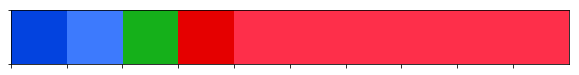

In [20]:
sns.palplot(sns.xkcd_palette(colors))

In [21]:
colors = sns.xkcd_palette(colors)

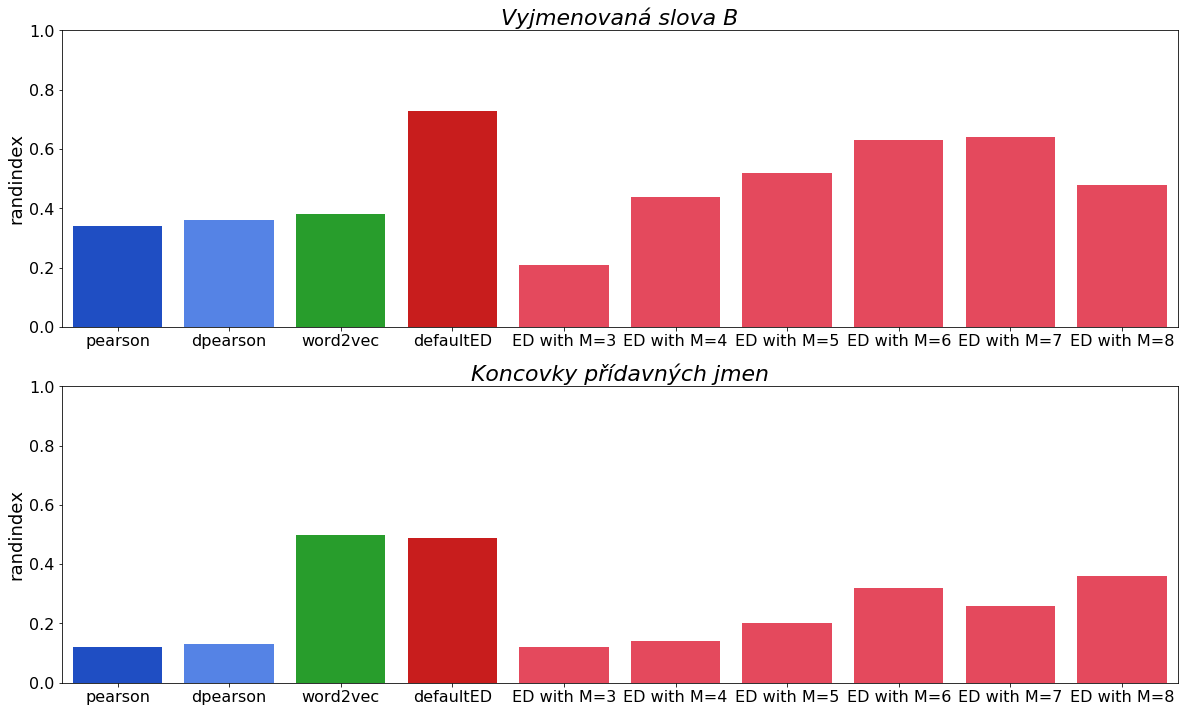

In [108]:
figure, (ax1,ax2) = plt.subplots(2,1)
figure.set_size_inches(20,12)

a1 = sns.barplot(data=datasets[0]['randindex'], ax=ax1, x='similarity', y='randindex', palette=colors)
a1.set(ylim=(0, 1))
a1.set_xlabel('')
a1.set_ylabel('randindex', fontsize=18)
a1.tick_params(axis='both', which='major', labelsize=16)
a1.set_title('Vyjmenovaná slova B', fontsize=22, fontstyle='italic')

a2 = sns.barplot(data=datasets[1]['randindex'], ax=ax2, x='similarity', y='randindex', palette=colors)
a2.set(ylim=(0, 1))
a2.set_xlabel('')
a2.set_ylabel('randindex', fontsize=18)
a2.tick_params(axis='both', which='major', labelsize=16)
a2.set_title('Koncovky přídavných jmen', fontsize=22, fontstyle='italic')
plt.savefig('visualizations/randindex-barplot.png')
plt.show()

# Visualizing only labeled data

In [17]:
data = labeled_word2vec_data

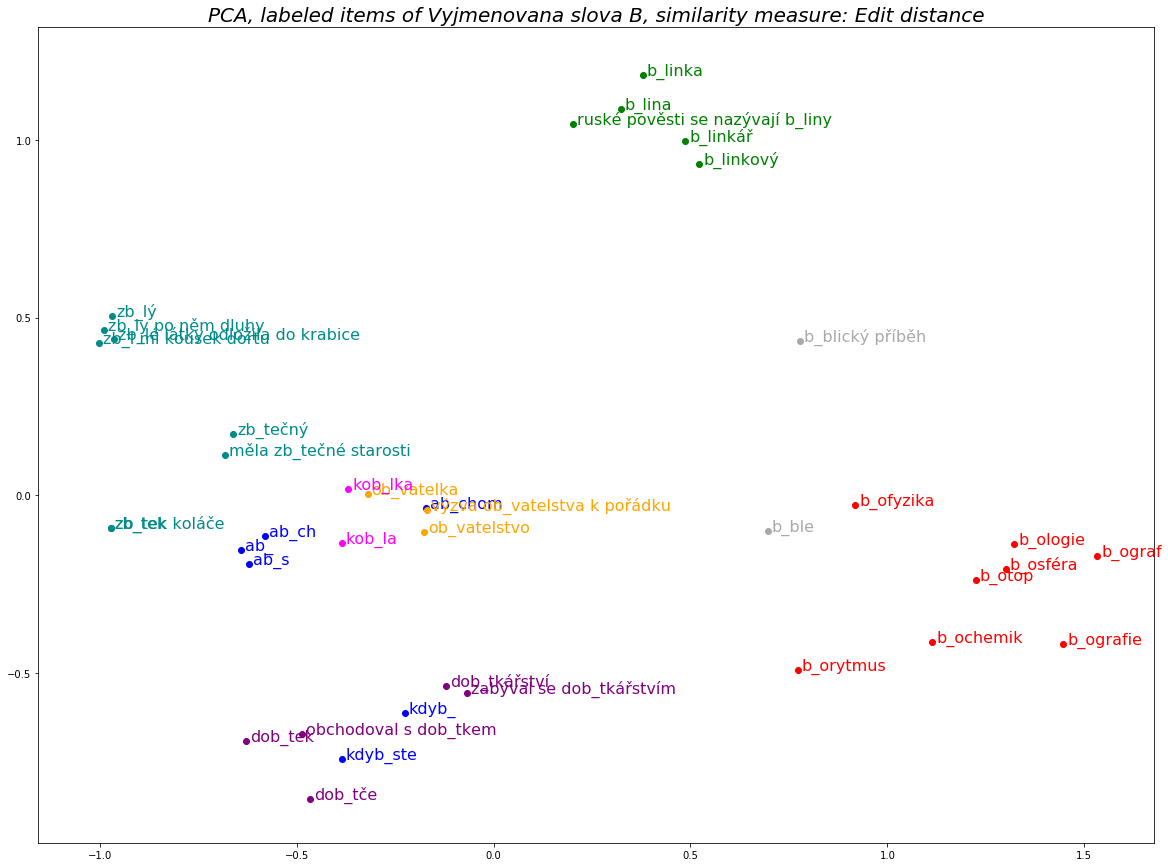

In [18]:
from sklearn.decomposition import PCA
from projections.base_projection import *
model = PCA(n_components=2)
result = model.fit_transform(editdistance)
x_positions = result[:, 0]
y_positions = result[:, 1]
colors = ['blue', 'green', 'red', 'darkcyan', 'magenta', 'orange', 'darkgray', 'purple']

data.reset_index(drop=True, inplace=True)
for i, row in data.iterrows():
    if row['manual_label'] != 0:
        plt.scatter(x_positions[i], y_positions[i], c=colors[row['manual_label'] - 1])
        plt.annotate(row['question'], xy=(x_positions[i]+0.01, y_positions[i]), color=colors[row['manual_label'] - 1], fontsize=16)
    else:
        plt.scatter(x_positions[i], y_positions[i], c='black')
        plt.annotate(row['question'], xy=(x_positions[i]+0.01, y_positions[i]), color='black')
plt.gcf().set_size_inches(20, 15)
plt.title('PCA, labeled items of Vyjmenovana slova B, similarity measure: Edit distance', fontsize=20, fontstyle='italic')
# plt.savefig('visualizations/labeleditems-editdistance-vyjmenovanaslovaB.png')
plt.show()

# Hierarchical clustering's dendrogram

In [19]:
import numpy as np
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [20]:
clustering = AgglomerativeClustering(n_clusters=len(dataset['labels']), affinity='euclidean', linkage='ward')

In [21]:
labels = labeled_word2vec_data['solution'].tolist()
colors = ['blue', 'green', 'red', 'darkcyan', 'magenta', 'orange', 'darkgray', 'purple']
hierarchy.set_link_color_palette(colors)

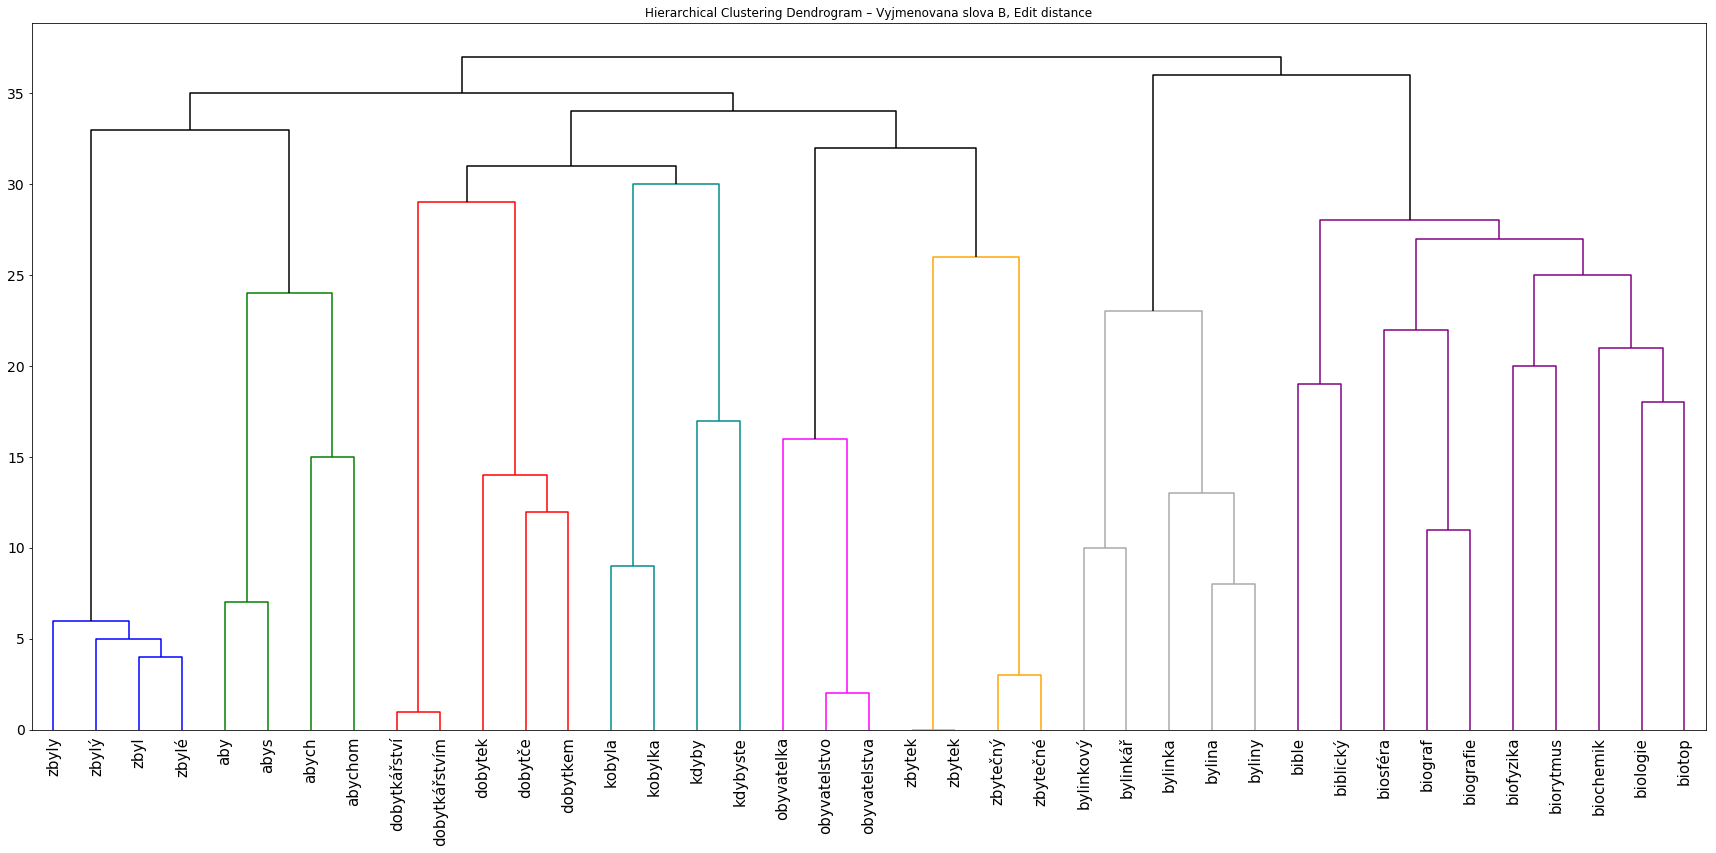

In [22]:
model = clustering.fit(editdistance)
plot_dendrogram(model, labels=labels, color_threshold=31, above_threshold_color='black', leaf_font_size=15, leaf_rotation=90)
plt.gcf().set_size_inches(30,13)
plt.yticks(fontsize=14)
plt.title('Hierarchical Clustering Dendrogram – Vyjmenovana slova B, Edit distance')
plt.show()

In [23]:
model = clustering.fit_predict(editdistance)

In [24]:
df = pd.DataFrame({'label': model, 'word': labels})
df.sort_values(['label'])

,label,word
19,0,kobylka
4,0,kdyby
5,0,kdybyste
18,0,kobyla
33,1,dobytkářstvím
32,1,dobytkem
11,1,dobytek
12,1,dobytče
13,1,dobytkářství
31,2,byliny
